# Bow-Tie I

In this toy model, we will show how Dlink works in simple directed, sparse networks with two clusters bonded by a single node. This is a expected topology for a nodes with overlapping community memberships (NOC). First, let's import some libraries.

In [1]:
T = True
F = False
# Stadard python libs ----
import numpy as np
# Personal libs ----
from networks.toy import TOY
from modules.hierarmerge import Hierarchy
from modules.colregion import colregion
from plotting_jupyter.plotting_H import Plot_H
from various.network_tools import get_labels_from_Z, get_best_kr, get_best_kr_equivalence, print_principal_memberships

The make_toys function, as its name suggest, creates the networks that we are going to use in this example. It produces 12 networks, but we will just cover four: toy_0, toy_6, toy_3, and toy_1. As it can be read in the code, the networks with seve nodes have a basic layout with two main clusters with strong connections. There also node A which can have six out of the twelve connections with two different strenghts. The algorithm places the six conenctions in a sequence.

In [2]:
def make_toys(linkage, **kwargs):
  ww = 1
  ws = 5

  toy = np.array(
    [
      [0, -1, -1, -1, -1, -1, -1],
      [-1, 0, ws, ws, 0, 0, 0],
      [-1, 0, 0, ws, 0, 0, 0],
      [-1 ,ws ,0, 0, 0, 0 ,0],
      [-1, 0, 0, 0, 0, ws, ws],
      [-1, 0, 0, 0, ws, 0, 0],
      [-1, 0, 0, 0, ws, ws, 0]
    ]
  )

  n = (toy.shape[0] - 1) * 2
  A = np.array(
    [
      ww, ww, ww,
      ws, ws, ws,
      0, 0, 0,
      0, 0, 0
    ]
  )
  x = np.arange(n)
  NETS = []
  rows, cols = np.where(toy == -1)
  for i in np.arange(n):
    wheel = np.zeros(n)
    wheel[i:] = x[:(n-i)]
    wheel[:i] = x[(n-i):]
    wheel = wheel.astype(int)
    toy_copy = toy.copy()
    toy_copy[rows, cols] = A[wheel]
    NETS.append(
      TOY(toy_copy.astype(float), linkage, **kwargs)
    )
  return n, NETS

Here, we set up the code to run the link communities, compute the quality functions, and extract the node hierarchy, as usual.

In [3]:
linkage = "single"
nlog10 = F
lookup = F
prob = F
cut = F
mode = "ALPHA"
topology = "MIX"
index = "jacp"
opt_score = ["_maxmu"]
nodes = 7

properties = {
  "nlog10" : nlog10,
  "lookup" : lookup,
  "prob" : prob,
  "cut" : cut,
  "topology" : topology,
  "index" : index,
  "mode" : mode
}

N, NETS = make_toys(linkage, **properties)
original_labels = np.array(["A", "B", "C", "D", "E", "F", "G"])
labels_dict = dict()
for i in np.arange(nodes):
  labels_dict[i] = original_labels[i]
toy_names = np.arange(N).astype(int).astype(str)

HS = []
for i, net in enumerate(NETS):
  print(f"\n\n\tAnalysing toy: {toy_names[i]}")
  net.set_labels(original_labels)
  h = Hierarchy(
    net, net.A, net.A, np.zeros(net.A.shape),
    nodes, linkage, mode
  )
  ## Compute features ----
  h.BH_features_cpp()
  ## Compute lq arbre de merde ----
  h.la_abre_a_merde_cpp(h.BH[0])
  # Set labels to network ----
  L = colregion(net, labels=net.labels)
  L.get_regions()
  h.set_colregion(L)
  HS.append(h)
score = "_maxmu"



	Analysing toy: 0


/Users/jmarti53/Documents/Projects/LINKPROJECT/Dlink/modules/simanalysis.py:56: RuntimeWarning: Mean of empty slice
  aki[i, i] = np.nanmean(


Computing features over mu-score space
Alpha: 6 and Beta: 0.0100
Alpha: 6 and Beta: 0.0733
Alpha: 6 and Beta: 0.1367
Alpha: 6 and Beta: 0.2000
Alpha: 6 and Beta: 0.4000


	Analysing toy: 1
Commencer: la abre a merde
Adding exceptional nodes.
Voila, bon ami
Computing features over mu-score space
Alpha: 6 and Beta: 0.0100
Alpha: 6 and Beta: 0.0733
Alpha: 6 and Beta: 0.1367
Alpha: 6 and Beta: 0.2000
Alpha: 6 and Beta: 0.4000


	Analysing toy: 2
Commencer: la abre a merde
Voila, bon ami
Computing features over mu-score space
Alpha: 6 and Beta: 0.0100
Alpha: 6 and Beta: 0.0733
Alpha: 6 and Beta: 0.1367
Alpha: 6 and Beta: 0.2000
Alpha: 6 and Beta: 0.4000


	Analysing toy: 3
Computing features over mu-score space
Alpha: 6 and Beta: 0.0100
Alpha: 6 and Beta: 0.0733
Commencer: la abre a merde
Alpha: 6 and Beta: 0.1367
Voila, bon ami
Alpha: 6 and Beta: 0.2000
Alpha: 6 and Beta: 0.4000


	Analysing toy: 4
Commencer: la abre a merde
Voila, bon ami
Computing features over mu-score space
Alpha: 6 an

/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is co

In this network, the node A has only outlinks. We can see in the first plot the link communities colored in the adjacency matrix. The matrix was arranged using the node dendrogram. In the second plot, we can see that nodes BCD and EFG are forming two clusters. Node A which is not colored was left behid, and as it is seeing in the dendrogram (third), it is cluster only once the other two communities are merged. In the last plot, we can see the link membership of the network and notice how the links from A belong to the two groups.

{'A': [0, 1]}
{0: ['B', 'C', 'D'], 1: ['E', 'F', 'G']}
Visualize k LCs!!!
Draw networkx!!!
Visualize node-community dendrogram!!!
Draw networkx link communities!!!


/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


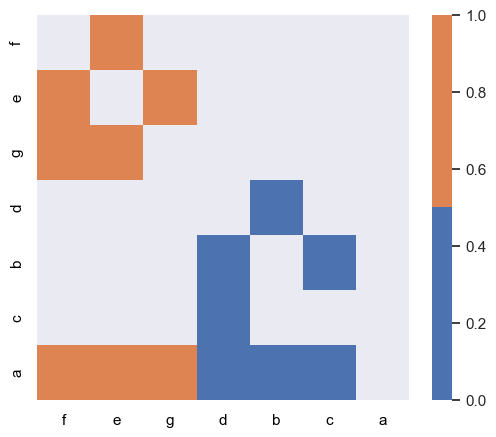

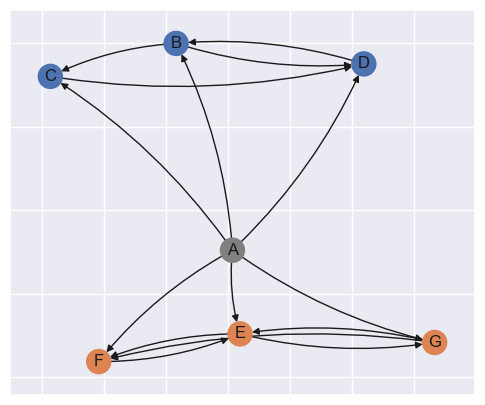

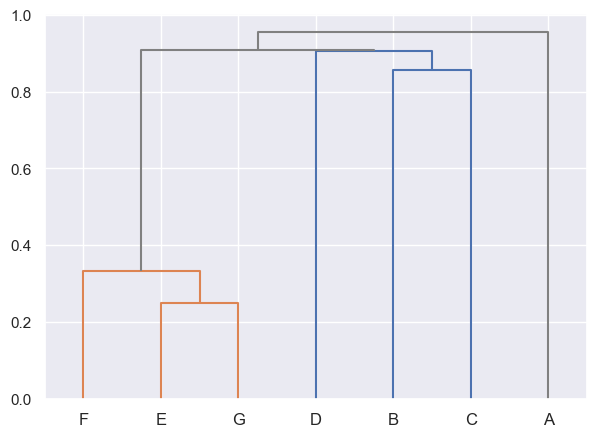

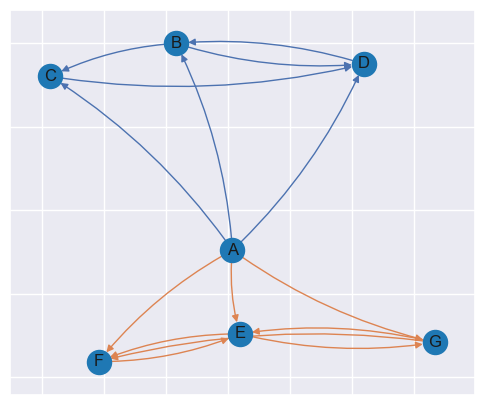

In [4]:
i = 0
# Plot H ----
plot_h = Plot_H(NETS[i], HS[i])
# Get best k and r ----
k, r = get_best_kr(score, HS[i])                                          # <------ Very interesting. Why?
rlabels = get_labels_from_Z(HS[i].Z, r)
_, nocs_membership = HS[i].get_ocn_discovery(k, rlabels)
# Which are the NOCs?
print(nocs_membership)
# Which are the nodes that belong to a particular community?
print_principal_memberships(rlabels, HS[i].colregion.labels)
# Plots
plot_h.lcmap_dendro(
  [k], cmap_name="deep", figwidth=6, figheight=5
)
plot_h.plot_networx(
  rlabels, cmap_name="deep", figwidth=6, figheight=5,
  labels=labels_dict
)
plot_h.core_dendrogram(
  [r], cmap_name="deep", figwidth=7, figheight=5
)
plot_h.plot_link_communities(
  k, cmap_name="deep", figwidth=6, figheight=5,
  labels=labels_dict
)

This example is similar to the first, but node A has only inlinks.

{'A': [0, 1]}
{0: ['B', 'C', 'D'], 1: ['E', 'F', 'G']}
Visualize k LCs!!!
Draw networkx!!!
Visualize node-community dendrogram!!!
Draw networkx link communities!!!


/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


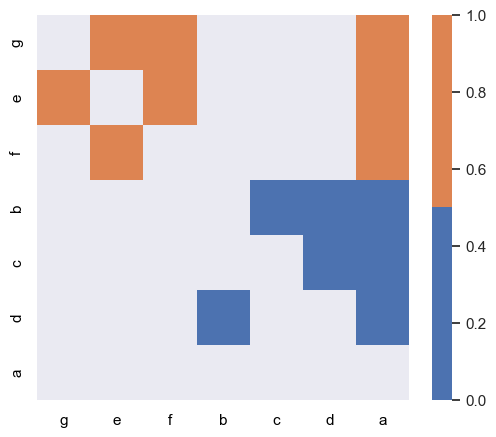

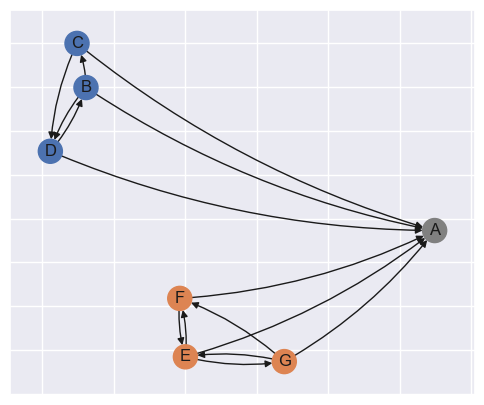

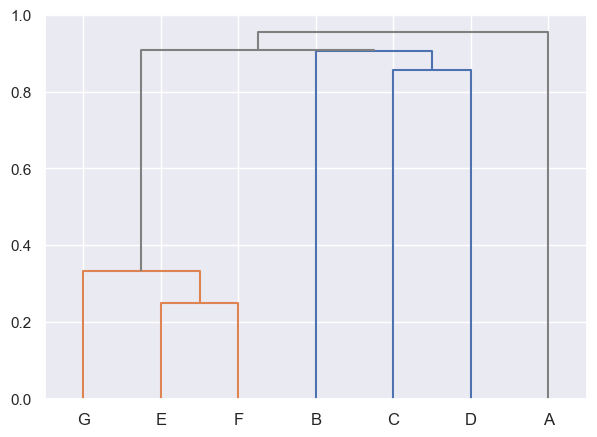

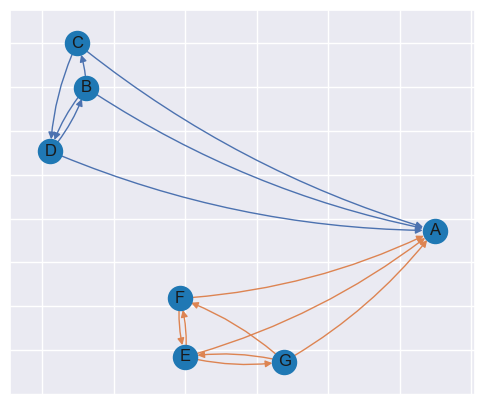

In [5]:
i = 6
# Plot H ----
plot_h = Plot_H(NETS[i], HS[i])
# Get best k and r ----
k, r = get_best_kr(score, HS[i])                                          # <------ Very interesting. Why?
rlabels = get_labels_from_Z(HS[i].Z, r)
_, nocs_membership = HS[i].get_ocn_discovery(k, rlabels)
# Which are the NOCs?
print(nocs_membership)
# Which are the nodes that belong to a particular community?
print_principal_memberships(rlabels, HS[i].colregion.labels)
# Plots
plot_h.lcmap_dendro(
  [k], cmap_name="deep", figwidth=6, figheight=5
)
plot_h.plot_networx(
  rlabels, cmap_name="deep", figwidth=6, figheight=5,
  labels=labels_dict
)
plot_h.core_dendrogram(
  [r], cmap_name="deep", figwidth=7, figheight=5
)
plot_h.plot_link_communities(
  k, cmap_name="deep", figwidth=6, figheight=5,
  labels=labels_dict
)

In this example, the node A's links create a flow whihc has the topological role of connecting the two categories in only one direction.

{'A': [0, 1]}
{0: ['A', 'E', 'F', 'G'], 1: ['B', 'C', 'D']}
Visualize k LCs!!!
Draw networkx!!!
Visualize node-community dendrogram!!!
Draw networkx link communities!!!


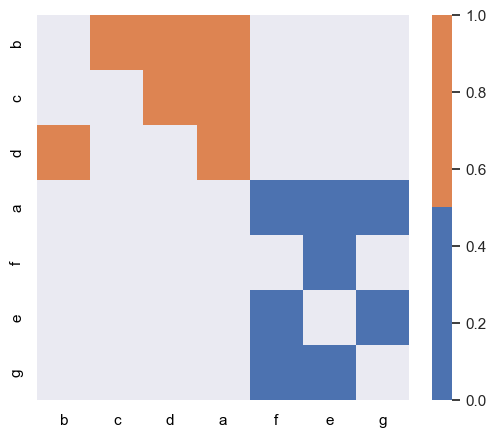

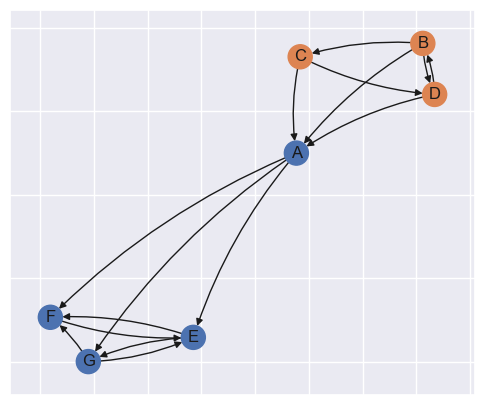

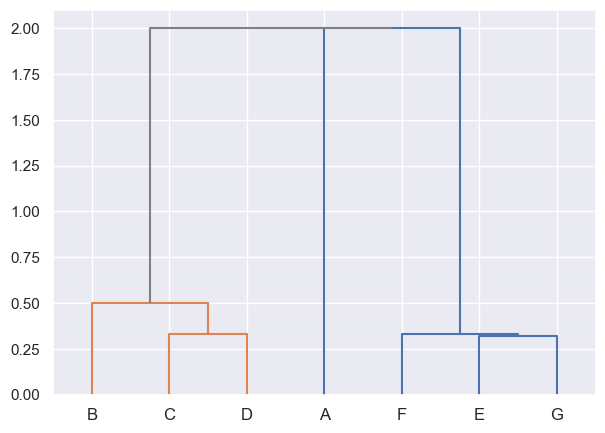

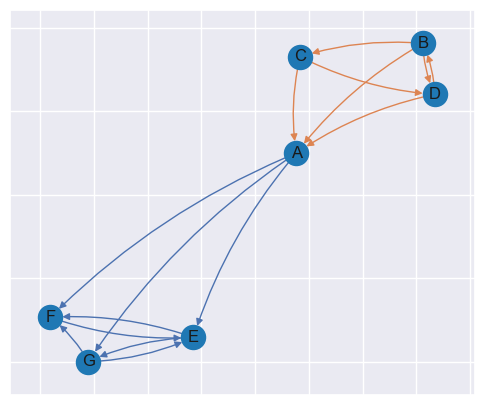

In [6]:
i = 3
# Plot H ----
plot_h = Plot_H(NETS[i], HS[i])
# Get best k and r ----
k, r = get_best_kr(score, HS[i])                                          # <------ Very interesting. Why?
rlabels = get_labels_from_Z(HS[i].Z, r)
_, nocs_membership = HS[i].get_ocn_discovery(k, rlabels)
# Which are the NOCs?
print(nocs_membership)
# Which are the nodes that belong to a particular community?
print_principal_memberships(rlabels, HS[i].colregion.labels)
# Plots
plot_h.lcmap_dendro(
  [k], cmap_name="deep", figwidth=6, figheight=5
)
plot_h.plot_networx(
  rlabels, cmap_name="deep", figwidth=6, figheight=5,
  labels=labels_dict
)
plot_h.core_dendrogram(
  [r], cmap_name="deep", figwidth=7, figheight=5
)
plot_h.plot_link_communities(
  k, cmap_name="deep", figwidth=6, figheight=5,
  labels=labels_dict
)

Lastly, in the last example, the network has some in- and outlinks. We can see a very interesting phenomenon regardin link communities in sparse directed networks. We can see that in the best partition, only one group appears (second plot).

{'A': [0]}
{0: ['E', 'F', 'G']}
Visualize k LCs!!!
Draw networkx!!!
Visualize node-community dendrogram!!!
Draw networkx link communities!!!


/usr/local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1096: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


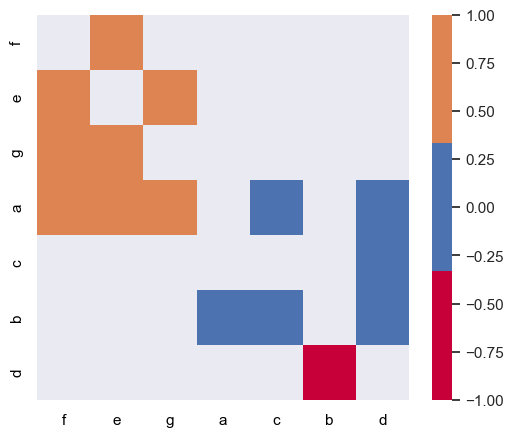

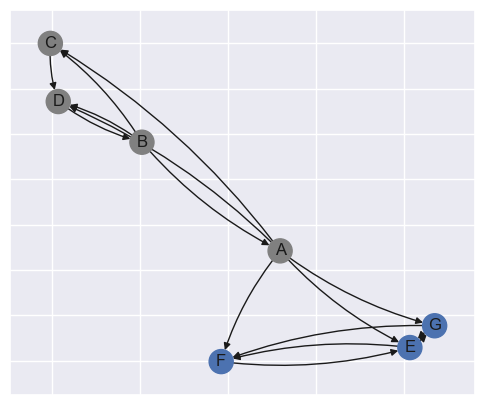

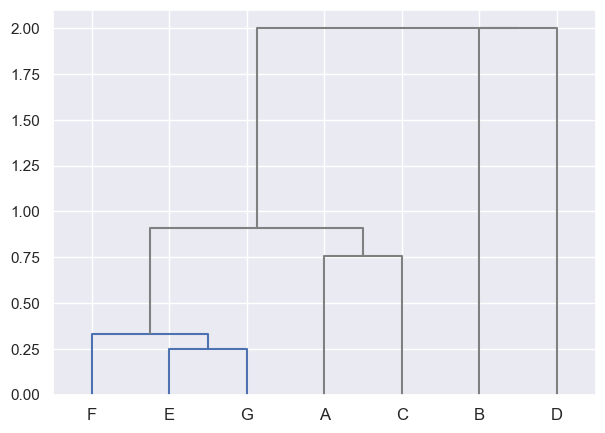

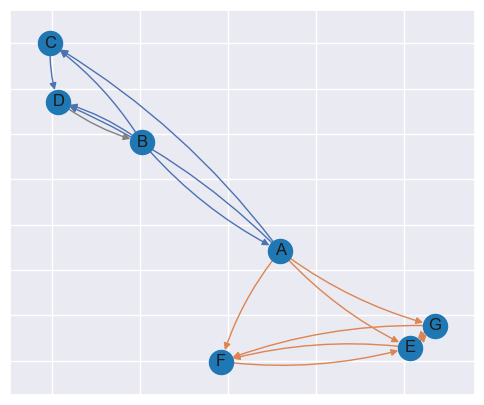

In [7]:
i = 1
# Plot H ----
plot_h = Plot_H(NETS[i], HS[i])
# Get best k and r ----
k, r = get_best_kr(score, HS[i])                                          # <------ Very interesting. Why?
rlabels = get_labels_from_Z(HS[i].Z, r)
_, nocs_membership = HS[i].get_ocn_discovery(k, rlabels)
# Which are the NOCs?
print(nocs_membership)
# Which are the nodes that belong to a particular community?
print_principal_memberships(rlabels, HS[i].colregion.labels)
# Plots
plot_h.lcmap_dendro(
  [k], cmap_name="deep", figwidth=6, figheight=5
)
plot_h.plot_networx(
  rlabels, cmap_name="deep", figwidth=6, figheight=5,
  labels=labels_dict
)
plot_h.core_dendrogram(
  [r], cmap_name="deep", figwidth=7, figheight=5
)
plot_h.plot_link_communities(
  k, cmap_name="deep", figwidth=6, figheight=5,
  labels=labels_dict
)